# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import json
import sys
from PIL import Image
import re
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2

## Pulling relevant data

In [2]:
with open('data_2.json', 'r', encoding='UTF-8') as f:
    data = json.load(f)

book_links = data['book_links']
shelf_links = data['shelves']
shelf_values = data['shelf_values']
len(shelf_values)

10000

## Exploring Word Possibilities

Drawing inspiration from Emotion Detection and Sentiment Analysis of Images (https://faculty.cc.gatech.edu/~hays/7476/projects/Aditi_Vasavi.pdf) breaking down emotional groups into the six categories defined by the famous psychologist Ekman: Happiness, Sadness, Fear, Disgust, Anger and Surprise

#### Trying to find synonyms using Natural Language Processing(NLTK) WordNet library

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/briankim/nltk_data...


True

In [8]:
#Checking synonym for the word "travel"
from nltk.corpus import wordnet#Creating a list 
synonyms = []
for syn in wordnet.synsets("happy"):
    for lm in syn.lemmas():
             synonyms.append(lm.name())#adding into synonyms
print (set(synonyms))

{'well-chosen', 'happy', 'glad', 'felicitous'}


In [10]:
# Experimenting with getting a larger set
synonyms = []
word_set = ["happiness", "happy", "joy", "joyous", "delight", "cheer", "cheerful"]
for word_target in word_set:
    for syn in wordnet.synsets(word_target):
        for lm in syn.lemmas():
                 synonyms.append(lm.name())#adding into synonyms
print (set(synonyms))

{'cheerful', 'transport', 'felicity', 'joy', 'recreate', 'enchant', 'gladden', 'chirk_up', 'joyousness', 'enrapture', 'pep_up', 'jolly_up', 'felicitous', 'delectation', 'revel', 'urge', 'cheer', 'barrack', 'hearten', 'enthrall', 'pleasure', 'ravish', 'rejoice', 'sunniness', 'upbeat', 'enjoy', 'joyfulness', 'please', 'exhort', 'cheerfulness', 'pollyannaish', 'embolden', 'jolly_along', 'urge_on', 'happy', 'sunshine', 'root_on', 'happiness', 'well-chosen', 'cheer_up', 'glad', 'enthral', 'inspire', 'delight', 'joyous'}


In [13]:
sum(
    [
        1 for shelf in shelf_values if not set(shelf).isdisjoint(synonyms)
    ]
)

1966

In [ ]:
word_sets = [
    ["happiness", "happy", "joy", "joyous", "delight", "cheer", "cheerful"],
    ["sadness", "sad", "unhappy", "unhappiness"]
]

#### Trying to get synonyms using the Thesauras API

In [14]:
import requests

In [16]:
word = "happiness"
response = requests.get("https://api.api-ninjas.com/v1/thesaurus?word=" + word)

response.text

'{"error": "Missing API Key."}'

#### Trying to get synonyms by scraping Thesaurus.com

In [4]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [5]:
thes_url = "https://www.thesaurus.com/browse/"

In [6]:
def get_synonyms(url):
    url = thes_url + word
    page = urlopen(url)
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html, "html.parser")

    return [item.text for item in soup.findAll("div", {"data-testid": "word-grid-container"})[0].findAll("a")]

In [7]:
super_words = [
#     ["happiness", "happy", "joy", "joyful", "fun", "cheer", "cheery"],
    ["happiness", "happy", "joy", "joyful", "cheer", "cheery"],
    ["sadness", "sad", "depress", "depressing", "tragic", "unhappy", "unhappiness"],
    ["fear", "afraid", "wary", "scary", "scare", "fearful", "intimidate", "intimidating"],
    ["disgust", "disgusting", "gross", "icky"],
    ["anger", "angry", "rage", "wrath", "wrathful"]
]

In [8]:
syn_sets = []

for super_word_set in super_words:
    print(super_word_set)
    syn_set = set(super_word_set)
    for word in super_word_set:
        synonyms = get_synonyms(thes_url + word)
        tmp_synonyms = []
        
        for i, synonym in enumerate(synonyms):
            sys.stdout.write("\r" + str(i + 1) + "/" + str(len(synonyms)))
            sys.stdout.flush()
            tmp_synonyms.extend(get_synonyms(thes_url + synonym))
        
        
        syn_set.update(synonyms)
        syn_set.update(tmp_synonyms)
#         print(" ", len(tmp_synonyms), len(set(tmp_synonyms)), len(syn_set), len(set(synonyms + tmp_synonyms)))
        print()

    print(len(syn_set))
    syn_sets.append(syn_set)

['happiness', 'happy', 'joy', 'joyful', 'cheer', 'cheery']
47/47
49/49
49/49
36/36
26/26
5/5
164
['sadness', 'sad', 'depress', 'depressing', 'tragic', 'unhappy', 'unhappiness']
43/43
49/49
56/56
21/21
43/43
45/45
9/9
224
['fear', 'afraid', 'wary', 'scary', 'scare', 'fearful', 'intimidate', 'intimidating']
49/49
44/44
37/37
14/14
7/7
49/49
40/40
6/6
231
['disgust', 'disgusting', 'gross', 'icky']
22/22
47/47
14/14
10/10
90
['anger', 'angry', 'rage', 'wrath', 'wrathful']
48/48
53/53
52/52
26/26
17/17
152


In [9]:
len(syn_sets)

5

In [10]:
[len(syn_set) for syn_set in syn_sets]

[164, 224, 231, 90, 152]

In [11]:
[
    sum(
        [
            1 for shelf in shelf_values if not set(shelf).isdisjoint(list(syn_set))
        ]
    ) for syn_set in syn_sets
]

[316, 2392, 852, 58, 38]

In [12]:
sum(
    [
        1 for shelf in shelf_values if any(
            [
                not set(shelf).isdisjoint(list(syn_set)) for syn_set in syn_sets
            ]
        )
    ]
)

3290

In [13]:
# Counting duplicate occurrences
# sum(
#     [
#         1 for shelf in shelf_values if sum(
#             [
#                 1 for syn_set in syn_sets if not set(shelf).isdisjoint(list(syn_set))
#             ]
#         ) > 1
#     ]
# )

multiples = []

for i in range(len(book_links)):
    shelf = shelf_values[i]
    multiple_value = []
    for j, syn_set in enumerate(syn_sets):
        overlap = next((shelf_val for shelf_val in shelf if shelf_val in syn_set), None)
        if overlap is not None:
            multiple_value.append([j, overlap])
    if len(multiple_value) > 0:
        multiples.append(multiple_value)
            
len(multiples)

3290

In [14]:
sum([1 for multiple in multiples if len(multiple) == 2]), sum([1 for multiple in multiples if len(multiple) == 3]), sum([1 for multiple in multiples if len(multiple) == 4])

(350, 8, 0)

In [15]:
combinations = {}

for multiple in multiples:
    string = ""
    for item in multiple:
        string += str(item[0])
    if string in combinations:
        combinations[string] += 1
    else:
        combinations[string] = 1

len(combinations)

16

In [16]:
combinations

{'1': 2062,
 '2': 568,
 '12': 251,
 '0': 257,
 '01': 50,
 '124': 2,
 '3': 23,
 '23': 16,
 '4': 22,
 '14': 9,
 '123': 6,
 '24': 3,
 '13': 12,
 '02': 6,
 '04': 2,
 '03': 1}

In [17]:
y_classes = []
vals = []

for shelf in shelf_values:
    val = next((shelf_val for shelf_val in shelf if any([shelf_val in syn_set for syn_set in syn_sets])), -1)
    vals.append(val)
    if val == -1:
        y_classes.append(val)
    else:
        y_classes.append(syn_sets.index(next((syn_set for syn_set in syn_sets if val in syn_set))))

In [18]:
len(y_classes)

10000

In [19]:
sum([1 for y_class in y_classes if y_class > -1])

3290

In [20]:
sum([1 for val in vals if val == 'fun'])

0

In [21]:
sum([1 for val in vals if val == 'sad'])

1790

In [22]:
data = []

for i, y_class in enumerate(y_classes):
    data.append([str(i) + ".jpg", y_class])

with open('data_classes.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

## EDA With Classes

In [3]:
with open('./data_2.json', 'r', encoding='UTF-8') as f:
    data = json.load(f)

book_links = data['book_links']
shelf_links = data['shelves']
shelf_values = data['shelf_values']

In [4]:
with open('./data_classes.json', 'r') as f:
    data = json.load(f)

files = []
classes = []

for i in range(len(data)):
    if data[i][1] > -1:
        files.append(data[i][0])
        classes.append(data[i][1])

len(files), len(classes)

(3290, 3290)

In [5]:
values_dict = {
    0:"happiness",
    1:"sadness",
    2:"fear",
    3:"disgust",
    4:"anger"
}

In [6]:
classes[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 2, 1]

In [10]:
data_series = pd.Series([values_dict[c] for c in classes])

In [11]:
data_series.values

array(['sadness', 'sadness', 'sadness', ..., 'sadness', 'anger',
       'sadness'], dtype=object)

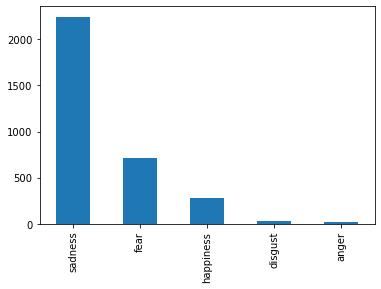

In [12]:
data_series.value_counts().plot.bar(x='Emotion', y='Number of Occurrences')

In [13]:
directory = "./data/images/"
dimensions = (200, 200)
num_classes = 5

In [14]:
shuffle_indices = shuffle(range(len(files)))
train_indices, test_indices = train_test_split(shuffle_indices, test_size=0.1, random_state=42, stratify=classes)
len(train_indices), len(test_indices)

(2961, 329)

In [23]:
# Loading images

X_train = []
y_train = []

print("train indices")

for place, i in enumerate(train_indices):
    filename = directory + files[i]
    if os.path.isfile(filename):
        X_train.append(cv2.resize(cv2.imread(filename), dimensions, interpolation=cv2.INTER_LINEAR))
        y_train.append(classes[i])
    else:
        print(filename)
        del train_indices[place]
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

print("test indices")

for place, i in enumerate(test_indices):
    filename = directory + files[i]
    if os.path.isfile(filename):
        X_test.append(cv2.resize(cv2.imread(filename), dimensions, interpolation=cv2.INTER_LINEAR))
        y_test.append(classes[i])
    else:
        print(filename)
        del test_indices[place]
        
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

train indices
test indices


((2960, 200, 200, 3), (2960,), (329, 200, 200, 3), (329,))

In [24]:
y_train[0:5]

array([0, 2, 1, 1, 0])

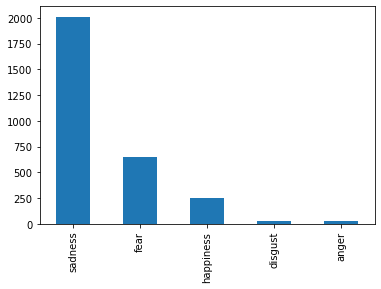

In [25]:
pd.Series([values_dict[c] for c in y_train]).value_counts().plot.bar(x='Emotion', y='Number of Occurrences')

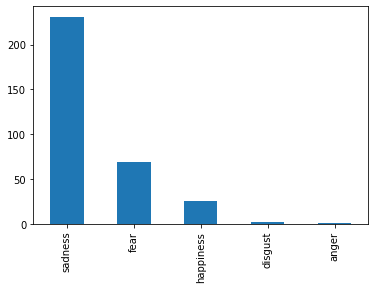

In [26]:
pd.Series([values_dict[c] for c in y_test]).value_counts().plot.bar(x='Emotion', y='Number of Occurrences')

(2960, 200, 200, 3)
2567 7027.jpg
/book/show/17704902-five-days-at-memorial


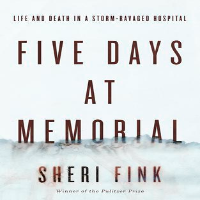

2895 8381.jpg
/book/show/20697435-the-book-of-strange-new-things


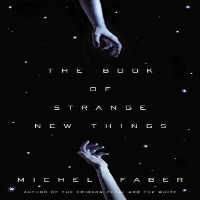

422 833.jpg
/book/show/21671.Mystic_River


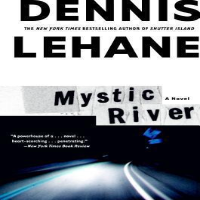

1824 4607.jpg
/book/show/760941.When_Rabbit_Howls


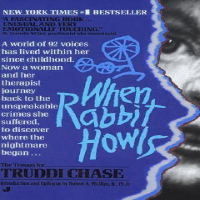

1820 4600.jpg
/book/show/6609758-numbers


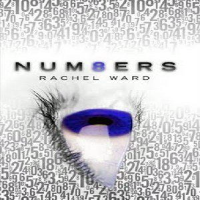

2812 8024.jpg
/book/show/25903764-ghosts


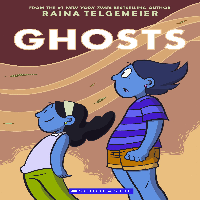

787 1703.jpg
/book/show/228630.Black_Boy


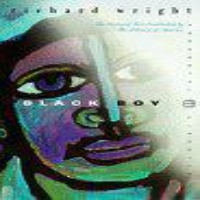

532 1099.jpg
/book/show/72579.Alias_Grace


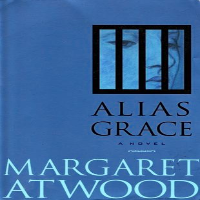

2910 8452.jpg
/book/show/8320840-the-complete-fiction


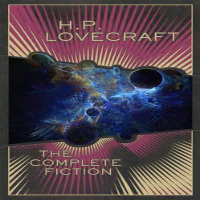

1576 3897.jpg
/book/show/6371117-betrayals


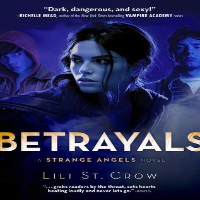

In [28]:
print(X_train.shape)
for i in np.random.choice(train_indices, size=10):
    print('========================================================')
    print(i, files[i])
    print(book_links[int(files[i][:-4])])
    # print(sum(np.where(train_indices == i)))
#     display(Image.open(directory + files[i]))
    display(Image.fromarray((X_train[np.where(train_indices == i)][0]).astype(np.uint8)))
    print('========================================================')

In [29]:
with open('./X_train_v3.npy', 'wb') as f:
    np.save(f, X_train)
with open('./y_train_v3.npy', 'wb') as f:
    np.save(f, y_train)
with open('./X_test_v3.npy', 'wb') as f:
    np.save(f, X_test)
with open('./y_test_v3.npy', 'wb') as f:
    np.save(f, y_test)
with open('./shuffle_train_indices_v3.npy', 'wb') as f:
    np.save(f, np.array(train_indices))
with open('./shuffle_test_indices_v3.npy', 'wb') as f:
    np.save(f, np.array(test_indices))